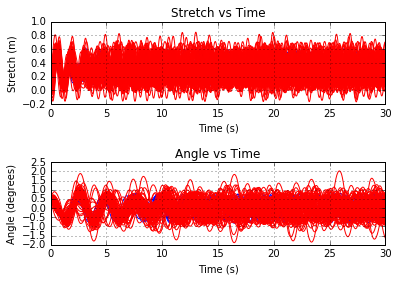

In [26]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import pandas as pd
from pandas import DataFrame, Series

# Solve x'' + (k/m)x - (l+x)(theta)^2 - gcos(theta) = 0, (theta)^2 + (gsin(theta) - 2x'theta')/(l+x)) = 0

# Convert to system of 1st order:
# y1' = y2 
# y2' = (-k/m)*y1 + (l+y1)*(y3)^2 + g*cos(y3)
# y3' = y4
# y4' = (-g*sin(y3) - 2*y2*y4)/(l+y1)
    
def pend(I,t, m, k, l, g):
    dy1dt = I[1]
    dy2dt = (-k/m)*I[0] + (l+I[0])*(I[2])**2 + g*math.cos(I[2])
    dy3dt = I[3]
    dy4dt = ((-g*math.sin(I[2])) - (2*I[1]*I[3]))/(l+I[0])

    return [dy1dt,dy2dt,dy3dt,dy4dt]

t=np.linspace(0,30,30000) #creating time array

numTrials = 100
parameterData=DataFrame()
parameterFailureData=DataFrame()
stretchData=DataFrame()
stretchFailureData=DataFrame()
angleData=DataFrame()
angleFailureData=DataFrame()

for trial in range(numTrials):
    #print("Trial #" + str(trial+1))
    
    #defining parameters
    pendMass=norm.rvs(1, 0.1)                   # pendulum mass (kilograms)
    springConst=norm.rvs(30, 0.25)              # spring constant (Newtons/meter)
    length=norm.rvs(1, 0.1)                     # unstretched pendulum length (meters)
    gravAccel=norm.rvs(9.8, 0.1)                # acceleration from gravity (meters/second^2)
    
    #defining initial conditions
    initStretch=norm.rvs(0.1, 0.01)             # initial stretch (meters)
    initStretchPrime=norm.rvs(0, .8)            # initial rate of change in stretch (meters/second)
    initAngle=norm.rvs(0.5, 0.01)               # initial angle of swing (degrees)
    initAnglePrime=norm.rvs(0, .8)              # initial rate of change in angle (degrees/second)
    initial_conditions = [initStretch, initStretchPrime, initAngle, initAnglePrime]    

    # calling odeint
    results=DataFrame(integrate.odeint(pend, initial_conditions, t, args=(pendMass, springConst, length, gravAccel)))    
    
    # Add results to data frames
    stretchSeries=Series(results[0])
    angleSeries=Series(results[2])
    maxAngle=angleSeries.max()
    if (maxAngle>10):
        angleFailureData=pd.concat([angleFailureData, angleSeries], axis=1)
        angleFailureData=angleFailureData.rename(columns={0:'trial'+str(trial)})
        stretchFailureData=pd.concat([stretchFailureData, stretchSeries], axis=1)
        stretchFailureData=stretchFailureData.rename(columns={0:'trial'+str(trial)})
        parameterFailureData=pd.concat([parameterFailureData, Series({'pendMass':pendMass, 'springConst':springConst, 'length':length, 'gravAccel':gravAccel, 'initStretch':initStretch, 'initStretchPrime':initStretchPrime, 'initAngle':initAngle, 'initAnglePrime':initAnglePrime})], axis=1)
        parameterFailureData=parameterFailureData.rename(columns={0:'trial'+str(trial)})
    else:
        angleData=pd.concat([angleData, angleSeries], axis=1) 
        angleData=angleData.rename(columns={2:'trial'+str(trial)})    
        stretchData=pd.concat([stretchData, stretchSeries], axis=1)
        stretchData=stretchData.rename(columns={0:'trial'+str(trial)})
        parameterData=pd.concat([parameterData, Series({'pendMass':pendMass, 'springConst':springConst, 'length':length, 'gravAccel':gravAccel, 'initStretch':initStretch, 'initStretchPrime':initStretchPrime, 'initAngle':initAngle, 'initAnglePrime':initAnglePrime})], axis=1)
        parameterData=parameterData.rename(columns={0:'trial'+str(trial)})
        
# Plot stretch
plt.subplot(2, 1, 1)    
plt.grid()
plt.title('Stretch vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Stretch (m)')
(rowCount, colCount)=stretchData.shape
for colNum in range(colCount):
    col=stretchData.iloc[:, colNum]
    plt.plot(t, col, 'b')
(rowCount, colCount)=stretchFailureData.shape  
for colNum in range(colCount):
    col=stretchFailureData.iloc[:, colNum]
    plt.plot(t, col, 'r')

# Plot angle
plt.subplot(2, 1, 2)
plt.grid()
plt.title('Angle vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
(rowCount, colCount)=angleData.shape
for colNum in range(colCount):
    col=angleData.iloc[:, colNum]
    plt.plot(t, col, 'b')
(rowCount, colCount)=angleFailureData.shape  
for colNum in range(colCount):
    col=angleFailureData.iloc[:, colNum]
    plt.plot(t, col, 'r')

plt.subplots_adjust(hspace = .7)
plt.savefig('Monte_Carlo_Plots.png')
  
# Save data to csv files
stretchData.to_csv('Stretch_Success_Data.csv', encoding='utf-8')
stretchFailureData.to_csv('Stretch_Failure_Data.csv', encoding='utf-8')  
angleData.to_csv('Angle_Success_Data.csv', encoding='utf-8')
angleFailureData.to_csv('Angle_Failure_Data', encoding='utf-8')
parameterData.to_csv('Parameter_Success_Data.csv', encoding='utf-8')
parameterFailureData.to_csv('Parameter_Failure_Data.csv', encoding='utf-8')